### Betting size

Machine Learning Algorithm의 결과가 좋게 나오더라도 Betting size를 적절하게 정하지 못하면 전략은 손실을 초래할 것이다. 

Machine Learning 에측을 통해 Betting size를 정하는 접근 방법에 대해서 알아본다

In [3]:
import numpy as np
from scipy.stats import norm, moment
import pandas as pd
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import datetime as dt

from FinancialMachineLearning.bet_sizing.ef3m import M2N, raw_moment, centered_moment

import warnings
warnings.filterwarnings('ignore')

from FinancialMachineLearning.bet_sizing.bet_sizing import (bet_size_probability, bet_size_dynamic, bet_size_budget, bet_size_reserve, confirm_and_cast_to_df, get_concurrent_sides, cdf_mixture, single_bet_size_mixed, M2N, raw_moment, most_likely_parameters, avg_active_signals, bet_size_power)

#### 전략 독립 베팅 크기 방식

거래 신호가 약해지기 전에 그 신호가 강해질 가능성에 대비해 현금을 확보할 수 있도록 포지션의 크기를 정하는 것을 선호한다. 선택할 수 있는 방법 중 하나는 Series $c_t = c_{t,l} - c_{t,s}$를 계산하는 것인데, 여기서 $c_{t,l}$은 시점 $t$에서 공존하는 롱 베팅 개수, $c_{t,s}$는 시점 $t$에서 공존하는 숏 베팅 개수이다. 여기서의 bet concurrency는 각 side에 대해 label concurrency를 계산한 것과 비슷한 방법으로 도출됐다. Lopez de Prado & Foreman(2014)에서 설명한 것과 같은 방법을 이용해 $\{c_t\}$에 두 Gaussian Distribution을 혼합한 것을 적용한다. Betting Size는 다음과 같이 유도된다

$$m_t=
\begin{cases}
\frac{F(c_t) - F(0)}{1 - F(0)}, ~~~~~ & \mbox{if } c_t \geq 0 \\
\frac{F(c_t) - F(0)}{F(0)}, & \mbox{if }c_t < 0 
\end{cases}$$

여기서 $F(x)$는 값 $x$에 대한 두 혼합 Gaussian Distribution의 fitting된 Cumulative Distribution Function이다. 예를 들어, 더 큰 값의 신호를 관찰할 확률이 단지 0.1일 때 베팅의 크기를 0.9로 설정할 수 있다. **신호가 강해질수록 신호가 더 강해질 확률은 점점 작아지므로, 이에 따라 베팅의 크기는 더욱 커진다**

**두 번째 방법**

두 번째 방법은 예산 관리 방식을 따르는 것이다. 공존 롱 베팅의 최대 개수 $\max _i(c_{i,l})$와 공존 숏베팅의 최대 개수 $\max _i(c_{i,s})$를 계산한다. 그런 다음 베팅 크기를 다음과 같이 유도한다

$$m_t = c_{t,l}\frac{1}{\max_i(c_{i,l})} - c_{t,s}\frac{1}{\max_i(c_{i,s})}$$

여기서 $c_{t,l}$은 시점 $t$에서의 공존 롱 베팅 개수, $c_{t,s}$는 시점 $t$에서의 공존 숏 베팅 개수이다. 목표는 마지막 공존 신호가 발생하기 전에 최대 포지션에 도달하지 않도록 하는 것이다

**세 번째 방법**

세 번째 방법은 Meta Labeling을 적용하는 것이다. SVC나 Random Forest와 같은 분류기를 적합화해 분류 확률을 결정하고, 이 확률을 사용해 베팅 크기를 도출한다. 이 방법은 몇 가지 장점이 있다

1. 베팅 크기를 결정하는 Machine Learning Algorithm은 Primary Model과 독립적이어서 거짓 양의 전조가 되는 특성을 포함할 수 있다
2. 예측된 확률을 바로 베팅 크기로 바꿀 수 있다

#### 예측된 확률로부터의 베팅 크기 조절

$p(x)$는 label $x$가 나타날 확률이라고 표기하자. 두 가지 가능한 output $x \in \{-1, 1\}$에 대해 귀무가설 $H_0 : p(x=1)=\frac{1}{2}$을 검정해 보려고 한다. 검정 통계량 $z = \frac{p(x = 1) - \frac{1}{2}}{\sqrt{p(x=1)(1-p(x=1))}} = \frac{2 p(x=1) - 1}{2 \sqrt{p(x=1)(1 - p(x=1))}} \sim Z, z \in (- \infty, + \infty)$을 계산한다. $Z$는 표준 정규 분포를 나타낸다. 베팅 크기는 $m = 2Z(z) - 1$로 도출하고, $m \in [-1, 1]$이며 $Z$는 Cumulative Distribution Function이다

가능한 결과의 개수가 2개를 넘을 때는 one-over-rest 방법을 사용한다. $X = \{-1, \dots, 0, \dots, 1\}$가 베팅 크기에 연계된 다양한 label이라 하고, $x \in X$를 예측된 label이라고 하자. 다시 말해 label은 label과 연계된 베팅 크기에 의해 식별된다. 각 label $i = 1, \dots, \parallel X \parallel$에 대해 확률 $p_i$를 추정한다. 단 $\sum_{i=1}^{\parallel X \parallel}p_i = 1$이다. $\tilde{p} = \max_i(p_i)$을 $x$의 확률로 정의하고 $H_0 : \tilde{p} = \frac{1}{\parallel X \parallel}$를 테스트 해 보자

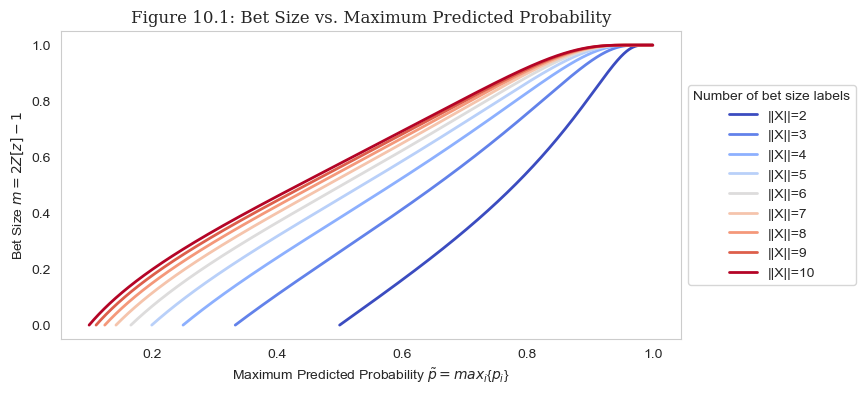

In [4]:
num_classes_list = [i for i in range(2, 11, 1)]  # array of number of classes, 2 to 10
sample_size = 10_000  # number of points to plot
colors = iter(cm.coolwarm(np.linspace(0,1,len(num_classes_list))))

# === Setup the t1 Series, also used for exercise 10.2 ===
# Create the array of dates.
start_date = dt.datetime(2000, 1, 1)  # starting at 01-JAN-2000
date_step = dt.timedelta(days = 1)
dates = np.array([start_date + i * date_step for i in range(sample_size)])
# Create the array of shifted dates to be the end date of the bet.
shift_list = np.random.uniform(1., 25., sample_size)
shift_dt = np.array([dt.timedelta(days = d) for d in shift_list])
# Combine into a pandas.Series object
dates_shifted = dates + shift_dt
t1 = pd.Series(data = dates_shifted, index = dates)

# Start plotting loop.
fig_10_1, ax_10_1 = plt.subplots(figsize=(8, 4))

for num_classes in num_classes_list:
    # Create the array of random probabilities.
    min_prob, max_prob = 1 / num_classes, 1  # possible range for maximum predicted probability, [1/||X||, 1]
    P = np.linspace(min_prob, max_prob, sample_size, endpoint = False)  # range of maximum predicted probabilities to plot
    # Combine probabilities with 't1' Series into a DataFrame for the bet size function.
    events_n_classes = pd.DataFrame({'t1': t1, 'prob': P})
    events_n_classes['bet_size_prob'] = bet_size_probability(
        events = events_n_classes, 
        prob = events_n_classes['prob'], 
        num_classes = num_classes
    )
    ax_10_1.plot(events_n_classes['prob'], events_n_classes['bet_size_prob'], 
                 label = f"||X||={num_classes}", linewidth = 2, alpha = 1, color = colors.__next__())

ax_10_1.set_ylabel("Bet Size $m=2Z[z]-1$")
ax_10_1.set_xlabel(r"Maximum Predicted Probability $\tilde{p}=max_i${$p_i$}")
ax_10_1.set_title("Figure 10.1: Bet Size vs. Maximum Predicted Probability", fontsize = 12, fontfamily = 'Serif')
ax_10_1.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), title = "Number of bet size labels")
ax_10_1.grid(False)

plt.show()

검정 통계량 $z = \frac{\tilde{p} - \frac{1}{\parallel X \parallel}}{\sqrt{\tilde{p}(1 - \tilde{p})}} \sim Z$를 계산한다. $z[0, +\infty)$에서 베팅 크기를 $m = x(2Z(z)-1)$로 유도하는데, 여기서 $m \in [-1, 1]$이고, $Z(z)$는 예측 $x$에 대한 크기를 조절한다 (여기서 포지션 방향은 $x$에 의해 암시된다)

#### 실행 중인 베팅의 평균화

모든 베팅은 보유 기간과 연계되어 있어 처음 투자 아이디어 생성 시간과 최초로 배리어에 도달한 시간 사이의 간격 `t1`이 존재한다. 한 가지 방법은 새로운 베팅이 도착하면 이전 베팅을 덮어쓰는 것인데, 이 방법은 과도한 포트폴리오 회전율을 유발할 가능성이 있다. 보다 합리적인 방법은 주어지는 시간에 실행 중인 모든 베팅의 크기를 평균화하는 것이다. 다음은 이런 아이디어를 구현한 한 가지 방법을 보여 준다

In [9]:
from multiprocessing import cpu_count

# Draw random numbers from a uniform distribution (all bets are long)
np.random.seed(0)
sample_size = 10000
P_t = np.random.uniform(.5, 1., sample_size)  # array of random from uniform dist.
# Create events DataFrame from P_t and t1 (previous exercise).

events_2_classes = pd.DataFrame({'t1': t1, 'prob': P_t})
events_2_classes['bet_size_prob'] = bet_size_probability(
    events = events_2_classes, 
    prob = events_2_classes['prob'], 
    num_classes = 2
)

events_2_classes['side'] = 1

In [10]:
avg_active_bet_sizes = avg_active_signals(events_2_classes.rename(columns = {'bet_size_prob': 'signal'}), num_threads = cpu_count())
events_2_classes['avg_active_bet_size'] = avg_active_bet_sizes

print("The first 10 rows of the resulting DataFrame from Exercise 10.2:")
display(events_2_classes.head(10))
print("Summary statistics on the bet size columns:")
display(events_2_classes[['prob', 'bet_size_prob', 'avg_active_bet_size']].describe())

/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/multiprocess/fast_ewma.py:5: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit((float64[:], int64), nopython = False, nogil = True)
/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/multiprocess/fast_ewma.py:5: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit f

The first 10 rows of the resulting DataFrame from Exercise 10.2:


,t1,prob,bet_size_prob,side,avg_active_bet_size
2000-01-01,2000-01-21 20:43:30.210618,0.774407,0.488510,1,0.488510
2000-01-02,2000-01-25 07:13:15.607875,0.857595,0.693816,1,0.591163
2000-01-03,2000-01-14 21:38:28.572856,0.801382,0.550002,1,0.577443
2000-01-04,2000-01-08 05:12:59.927223,0.772442,0.484193,1,0.554130
2000-01-05,2000-01-24 08:07:48.432056,0.711827,0.360002,1,0.515304
2000-01-06,2000-01-30 17:55:31.225329,0.822947,0.602473,1,0.529832
2000-01-07,2000-01-08 16:41:03.286139,0.718794,0.373496,1,0.507499
2000-01-08,2000-01-10 11:19:27.425467,0.945887,0.951258,1,0.562969
2000-01-09,2000-01-27 15:38:17.949836,0.981831,0.999691,1,0.663679
2000-01-10,2000-01-16 06:03:18.062296,0.691721,0.321986,1,0.620967


Summary statistics on the bet size columns:


,prob,bet_size_prob,avg_active_bet_size
count,10000.000000,10000.000000,10000.000000
mean,0.748229,0.473318,0.473105
std,0.144803,0.312169,0.084277
min,0.500036,0.000058,0.159201
25%,0.622655,0.199764,0.416534
50%,0.746751,0.429563,0.473090
75%,0.874146,0.740689,0.530048
max,0.999989,1.000000,0.761827


In [4]:
events_10_3 = events_2_classes.copy()
concurrent_bets = get_concurrent_sides(events_10_3['t1'], events_10_3['side'])
active_long_max, active_short_max = concurrent_bets['active_long'].max(), concurrent_bets['active_short'].max()
print(f"  10.3(a) Maximum number of concurrent long bets: {active_long_max}")
print(f"  10.3(b) Maximum number of concurrent short bets: {active_short_max}")

# 10.3(c) Bet size as difference between fractions of concurrent long and short bets
# Handle possible division by zero.
df_budget = bet_size_budget(events_10_3['t1'], events_10_3['side'])
df_budget = df_budget.rename(columns={'bet_size': 'bet_size_budget'})

display(df_budget.head(10))

  10.3(a) Maximum number of concurrent long bets: 20
  10.3(b) Maximum number of concurrent short bets: 0


,t1,side,active_long,active_short,bet_size_budget
2000-01-01,2000-01-09 05:11:26.367469,1,1,0,0.05
2000-01-02,2000-01-17 06:46:22.459752,1,2,0,0.10
2000-01-03,2000-01-15 07:46:59.476963,1,3,0,0.15
2000-01-04,2000-01-23 12:16:14.317826,1,4,0,0.20
2000-01-05,2000-01-13 07:39:46.993336,1,5,0,0.25
2000-01-06,2000-01-26 17:56:01.877342,1,6,0,0.30
2000-01-07,2000-01-16 09:27:08.001976,1,7,0,0.35
2000-01-08,2000-01-31 09:35:03.749123,1,8,0,0.40
2000-01-09,2000-01-10 06:37:45.153003,1,9,0,0.45
2000-01-10,2000-01-12 17:10:11.718227,1,9,0,0.45


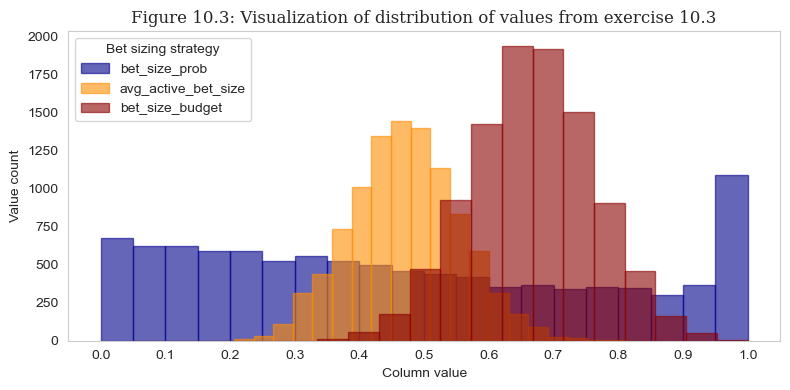

In [5]:
betsizes_10_3 = events_2_classes[['bet_size_prob', 'avg_active_bet_size']].copy()
betsizes_10_3['bet_size_budget'] = df_budget['bet_size_budget'].copy()

# Start plotting code.
fig_10_3, ax_10_3 = plt.subplots(figsize=(8, 4))
colors = iter(['darkblue','darkorange','darkred'])
n_bins = 20
for i, col in enumerate(['bet_size_prob', 'avg_active_bet_size', 'bet_size_budget']):
    coo = colors.__next__()
    ax_10_3.hist(betsizes_10_3[col], bins=n_bins, alpha = 0.6, color = coo, label=col, edgecolor = coo)
ax_10_3.set_xticks([i/10 for i in range(11)])
ax_10_3.set_xlabel("Column value")
ax_10_3.set_ylabel("Value count")
ax_10_3.set_title("Figure 10.3: Visualization of distribution of values from exercise 10.3", fontsize=12, fontfamily='Serif')
ax_10_3.legend(loc="upper left", title="Bet sizing strategy")
fig_10_3.tight_layout()
ax_10_3.grid(False)
plt.show()

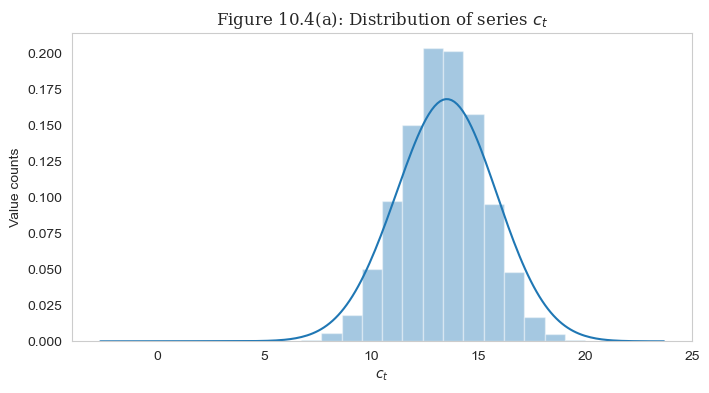

In [6]:
df_events_10_4 = df_budget.copy()
df_events_10_4['c_t'] = df_events_10_4['active_long'] - df_events_10_4['active_short']
fig_10_4, ax_10_4 = plt.subplots(figsize = (8,4))
ax_10_4a = sns.distplot(df_events_10_4['c_t'], bins = 20, kde=True, kde_kws={"bw":0.6}, norm_hist=False, ax=ax_10_4)
ax_10_4a.set_xlabel('$c_t$')
ax_10_4.set_ylabel("Value counts")
ax_10_4a.set_title("Figure 10.4(a): Distribution of series $c_t$", fontsize=12, fontfamily = 'Serif')
ax_10_4.grid(False)
plt.show()

In [7]:
df_reserve, params = bet_size_reserve(df_events_10_4['t1'],
                                      df_events_10_4['side'],
                                      fit_runs=100,
                                      epsilon=1e-05,
                                      factor=5,
                                      variant=2,
                                      max_iter=100_000,
                                      num_workers=8,
                                      return_parameters=True)

print(params)

|#########################| Completed 100 of 100 fitting rounds.

{'mu_1': 12.58611, 'mu_2': 13.55391, 'sigma_1': 2.61045, 'sigma_2': 1.98351, 'p_1': 0.04726}


In [8]:
df_reserve

,t1,side,active_long,active_short,c_t,bet_size
2000-01-01,2000-01-09 05:11:26.367469,1,1,0,1,1.806348e-07
2000-01-02,2000-01-17 06:46:22.459752,1,2,0,2,1.152284e-06
2000-01-03,2000-01-15 07:46:59.476963,1,3,0,3,5.697730e-06
2000-01-04,2000-01-23 12:16:14.317826,1,4,0,4,2.440926e-05
2000-01-05,2000-01-13 07:39:46.993336,1,5,0,5,9.414540e-05
...,...,...,...,...,...,...
2027-05-14,2027-05-17 04:14:27.206776,1,13,0,13,3.981979e-01
2027-05-15,2027-06-05 16:51:50.618663,1,13,0,13,3.981979e-01
2027-05-16,2027-05-17 05:13:23.312961,1,13,0,13,3.981979e-01
2027-05-17,2027-05-23 06:20:12.014120,1,13,0,13,3.981979e-01


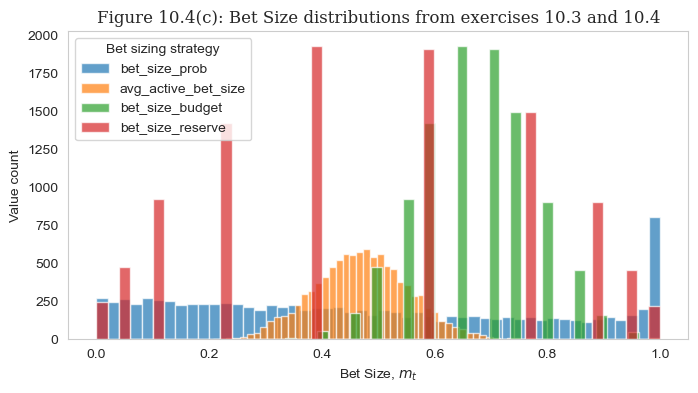

In [9]:
betsizes_10_4 = betsizes_10_3.copy()
betsizes_10_4['bet_size_reserve'] = df_reserve['bet_size']

fig_10_4c, ax_10_4c = plt.subplots(figsize = (8,4))
for c in betsizes_10_4.columns:
    ax_10_4c.hist(betsizes_10_4[c].to_numpy(), bins = 50, label = c, alpha = 0.7)
ax_10_4c.legend(loc='upper left', title="Bet sizing strategy")
ax_10_4c.set_xlabel("Bet Size, $m_t$")
ax_10_4c.set_ylabel("Value count")
ax_10_4c.set_title("Figure 10.4(c): Bet Size distributions from exercises 10.3 and 10.4", fontsize = 12, fontfamily = 'Serif')
ax_10_4c.grid(False)
ax_10_4.set_ylim((0, 2500))
plt.show()

In [10]:
print("Quantiles of the bet size values as calculated in the previous exercises:")
display(pd.concat([betsizes_10_4.quantile([0.001, 0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99, 0.999]),
                   betsizes_10_4.mean().to_frame(name='Mean').transpose()]))

Quantiles of the bet size values as calculated in the previous exercises:


,bet_size_prob,avg_active_bet_size,bet_size_budget,bet_size_reserve
0.001,0.000580,0.236408,0.3500,0.001218
0.01,0.006542,0.286157,0.4500,0.014335
0.05,0.037781,0.330472,0.5000,0.042464
0.25,0.199764,0.414410,0.6000,0.225883
0.5,0.429563,0.470466,0.6500,0.398198
0.75,0.740689,0.526693,0.7500,0.769636
0.95,0.997446,0.610695,0.8500,0.958637
0.99,1.000000,0.674243,0.9000,0.987195
0.999,1.000000,0.763611,0.9500,0.996792
Mean,0.473318,0.470965,0.6741,0.496788


#### 베팅 크기 이산화

평균화하면 불필요한 포트폴리오 회전율을 일부 감소시킬 수 있지만, 여전히 모들 예측마다 작은 거래들이 촉발될 수 있다. 이로 인한 불규칙 파형이 불필요한 과도한 트레이딩을 유발할 수 있으므로, 베팅 크기를 $m^* = \mathrm{round}(\frac{m}{d})d$, 여기서 $d \in (0, 1]$로 이산화할 것을 제안한다

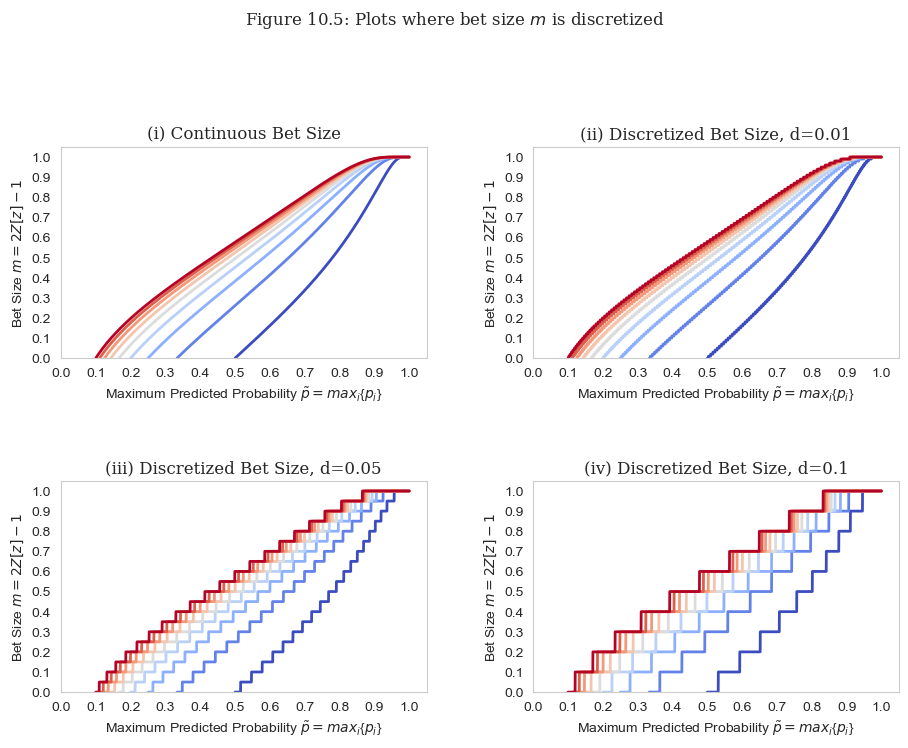

In [11]:
num_classes_list = [i for i in range(2, 11, 1)]  # array of number of classes, 2 to 10
n = 10_000  # number of points to plot

fig_10_5, ax_10_5 = plt.subplots(2, 2, figsize = (10, 8))
ax_10_5 = fig_10_5.get_axes()
d_list = [0.0, 0.01, 0.05, 0.1]
sub_fig_num = ['i', 'ii', 'iii', 'iv']
events_10_5 = events_2_classes.copy()  # reuse dataframe structure from previous

for i, axi in enumerate(ax_10_5):
    colors = iter(cm.coolwarm(np.linspace(0,1,len(num_classes_list))))
    for num_classes in num_classes_list:
        min_prob, max_prob = 1 / num_classes, 1  # possible range for maximum predicted probability, [1/||X||, 1]
        P = np.linspace(min_prob, max_prob, n, endpoint=False)  # range of maximum predicted probabilities to plot
        events_10_5['prob'] = P
        events_10_5['bet_size_prob'] = bet_size_probability(events=events_10_5, prob=events_10_5['prob'], step_size=d_list[i], num_classes=num_classes)
        axi.plot(events_10_5['prob'], events_10_5['bet_size_prob'], label=f"||X||={num_classes}", linewidth=2, alpha=1, color=colors.__next__())

    axi.set_ylabel("Bet Size $m=2Z[z]-1$")
    axi.set_xlabel(r"Maximum Predicted Probability $\tilde{p}=max_i${$p_i$}")
    axi.set_xticks([0.1*i for i in range(11)])
    axi.set_yticks([0.1*i for i in range(11)])
    #axi.legend(loc="upper left", title="Number of bet size labels")
    axi.set_ylim((0,1.05))
    axi.set_xlim((0, 1.05))
    d = d_list[i]
    if not d==0.0:
        axi.set_title(f"({sub_fig_num[i]}) Discretized Bet Size, d={d}", fontsize=12, fontfamily = 'Serif')
    else:
        axi.set_title(f"({sub_fig_num[i]}) Continuous Bet Size", fontsize=12, fontfamily = 'Serif')
    axi.grid(False)

fig_10_5.suptitle("Figure 10.5: Plots where bet size $m$ is discretized", fontsize=12, fontfamily = 'Serif')
fig_10_5.tight_layout(pad=4)
plt.show()

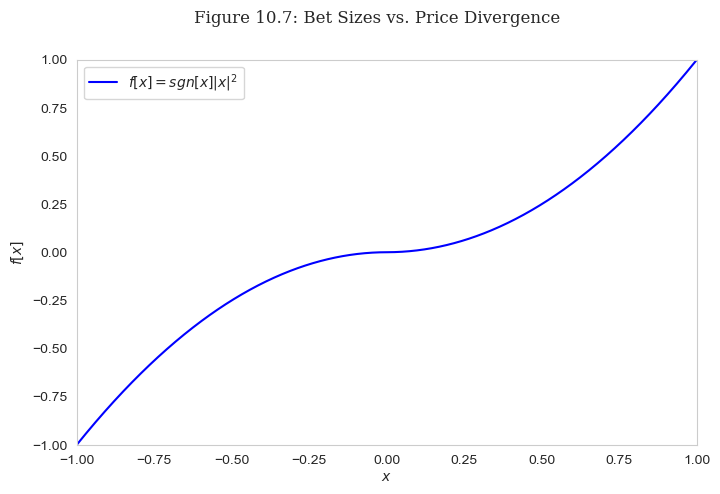

In [12]:
# setup data for replicating Figure 10.3
mP, f, wParams = 100, 115, {'divergence': 10, 'm': 0.95}
n_points = 1000
X = np.linspace(-1.0, 1.0, n_points)

w = 2
bet_sizes_power = np.array([bet_size_power(w, xi) for xi in X])

fig_10_7, ax_10_7 = plt.subplots(figsize=(8,5))
ax_10_7.plot(X, bet_sizes_power, label='$f[x]=sgn[x]|x|^2$', color='blue', linestyle='-')
ax_10_7.set_xlabel("$x$")
ax_10_7.set_ylabel("$f[x]$")
ax_10_7.set_xlim((-1, 1))
ax_10_7.set_ylim((-1, 1))
fig_10_7.suptitle("Figure 10.7: Bet Sizes vs. Price Divergence", fontsize=12, fontfamily = 'Serif')
plt.legend(loc='upper left')
plt.grid(False)
plt.show()